In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import shelve
import string
import numba as nb
import timeit
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib import colors



In [2]:
@nb.njit()
def frk4_step(y,u0,umid,u1,h,w,K,F,N):
    k1 = h * Fkuramoto_nb( y, u0,w,K,F,N)
    k2 = h * Fkuramoto_nb(y + 0.5 * k1, umid,w,K,F,N)
    k3 = h * Fkuramoto_nb( y + 0.5 * k2, umid,w,K,F,N)
    k4 = h * Fkuramoto_nb(y + k3, u1, w,K,F,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))

@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(ut[i]-x[i])
    return y

@nb.njit()
def whipeout(N, initlen, ut0,utmid,ut1, x0, h,w,p):
    uin, K,F= p[0],p[1], p[2]  
    for j in nb.prange(initlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
    return x

@nb.njit()
def kura_run(N,runlen, ut0, utmid,ut1, x0, h,w,p):
    uin, K,F = p[0],p[1], p[2]
    X = np.empty((N,runlen))
    for j in nb.prange(runlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
        X[:,j] = x
    return X

@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(ut[i]-x[i])
    return y

@nb.njit()
def frk4closed_step(y,p,pvec,Wout,w,h,N):
    k1 = h * fkura_closed( y,p,pvec,Wout,w,N)
    k2 = h * fkura_closed(y + 0.5 * k1, p,pvec,Wout,w,N)
    k3 = h * fkura_closed( y + 0.5 * k2, p,pvec,Wout,w,N)
    k4 = h * fkura_closed(y + k3, p,pvec,Wout,w,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))
    
@nb.njit()
def fkura_closed(x,p,pvec,Wout,w,N):  
    uin, K,F = p[0],p[1],p[2]
    one_hot = pvec   
    y = np.empty(N,dtype='float64')
    R1=0
    R2=0
    Up0= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))  
    for i in nb.prange(N):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(N):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(Up0[one_hot[i]]*uin-x[i]) 
    return y

def unroll_parameter(p_dict):
    N = p_dict['N']
    K = p_dict['K']
    uin = p_dict['uin']
    h = p_dict['h']
    mu = p_dict['mu']
    sigma = p_dict['sigma']
    w = p_dict['w']
    F = p_dict['F']
    reg = p_dict['reg']
    one_hot = p_dict['one_hot']
    testlen = p_dict['test']
    trainlen = p_dict['train']
    initlen = p_dict['init']
    data_scale = p_dict['data_scale']
    return N,K,uin,h,mu,sigma,w,F,reg,one_hot,testlen,trainlen,initlen,data_scale

@nb.njit()
def NMSE(yeval,ydata):
    
    nmse = np.zeros(yeval.shape[0], dtype='float64')
    for i in nb.prange(yeval.shape[0]):
        for j in nb.prange(yeval.shape[1]):
            nmse[i] += (ydata[i,j]-yeval[i,j])**2
        nmse[i]=nmse[i]/numba_norm(ydata[i,:])**2
    return nmse

@nb.njit() 
def numba_norm(a):
    n = a.shape[0]
    norm = 0
    for i in range(n):
        norm += a[i] * a[i]
    return np.sqrt(norm)

@nb.njit()
def nb_concatdot30( x, y): 
    res = np.zeros(3,dtype = 'float64')
    for i in nb.prange(x.shape[1]):
        if i==0:
            res[0]+=x[0,i]
            res[1]+=x[1,i]
            res[2]+=x[2,i]
        else:
            res[0]+=x[0,i]*y[i-1]
            res[1]+=x[1,i]*y[i-1]
            res[2]+=x[2,i]*y[i-1]
    return res

@nb.njit()
def concat_nb0(x,y):
    res = np.empty( (x.shape[0]+y.shape[0]), dtype = 'float64')
    for i in nb.prange(x.shape[0]+y.shape[0]):
        if i < x.shape[0]:
            res[i] = x[i]
        else:
            res[i] = y[i- x.shape[0] ]
    return res 


def training(data_scaled,p,pvec,w,h,N,initlen=2500,trainlen=10_000):
    ut0 =np.eye(3)[pvec] @ data_scaled[:,::20]
    utmid =np.eye(3)[pvec] @ data_scaled[:,10:][:,::20]
    ut1 =np.eye(3)[pvec] @  data_scaled[:,20:][:,::20]

    x=whipeout(N,initlen, ut0,utmid,ut1, np.linspace(0,2*math.pi,N), h, w,p)
    X0= kura_run(N,trainlen, ut0[:,initlen:],utmid[:,initlen:],ut1[:,initlen:], x,h,w,p)

    X =  np.concatenate((np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0),np.sin(X0)**2),axis=0)


    Yt = data_scaled [:,::20][:,(initlen+1):(initlen+trainlen+1)].T

    Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(2*N+1) , np.dot(X,Yt) ).T
    pred = (Wout @ X)
    nmse_train = NMSE(  np.dot(Wout,X), Yt.T).mean()

    u0 = Yt.T[:,-1] #(Wout @ X[:,-1]) # #
    x0= X0[:,-1] 

    return x0,Wout,nmse_train


def test_closed(x0,p,pvec,Wout,w,h,N,s_steps):
    Xtest=np.zeros((N,s_steps), dtype='float64')
    Upred=np.zeros((3,s_steps), dtype='float64')
    x=x0
    for i in nb.prange(s_steps):
        x = frk4closed_step(x,p,pvec,Wout,w,h,N)
        Xtest[:,i] = x
        Upred[:,i]= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))
    return Xtest, Upred




In [3]:

with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['lorenz'] 

In [4]:
with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['lorenz'] 

with shelve.open('shelve/param.shelve', 'r') as shelf:
    p_dict = shelf['lorenz']


N,K,uin,h,mu,sigma,w,F,reg,one_hot_output,testlen,trainlen,initlen, data_scale = unroll_parameter(p_dict)
data_scaled = data/data_scale
data_sampled= data_scaled [:,::20]

In [46]:
N,K,uin,h,mu,sigma,w,F,reg,one_hot_output,testlen,trainlen,initlen, data_scale = unroll_parameter(p_dict)
p = np.array([uin, K,F])
K,F= p[1],p[2]

testlen=10_000

In [51]:

K=16.86363636
F=18.04545455
p = np.array([uin, K,F])
K,F= p[1],p[2]

x0,Wout,nmse_train = training(data_scaled,p,one_hot_output,w,h,N,initlen=2500,trainlen=10_000)

Xtest, Upred=test_closed(x0,p,one_hot_output,Wout,w,h,N,10_000)

testlen=10_000
T=100+ np.arange(0,100,0.01)
tend=6750
Xdum = (Xtest[:,5000:tend] -3 ) % ( 2*np.pi )
Xind3d = np.where((np.abs(Xdum[0,:-1] - Xdum[0,1:])>4) | (np.abs(Xdum[2,:-1] - Xdum[2,1:])>4) \
| (np.abs(Xdum[4,:-1] - Xdum[4,1:])>4) )[0]

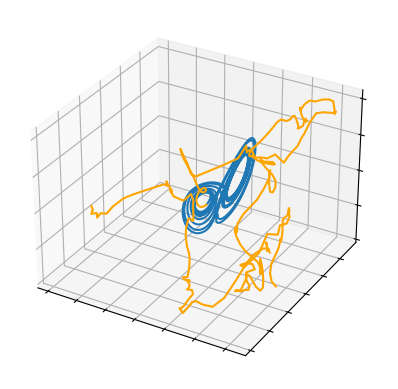

In [52]:
minter=1400
ax = plt.figure().add_subplot(projection='3d')
ax.plot(Xdum[0,:minter],Xdum[2,:minter] ,Xdum[4,:minter])
ax.plot(Xdum[0,minter:Xind3d[0]],Xdum[2,minter:Xind3d[0]] ,Xdum[4,minter:Xind3d[0]],color='orange')
rdum=0
for i in range(0,1):
    ax.plot(Xdum[0,(Xind3d[i]+1):(Xind3d[i+1]+1)],(Xdum[2,(Xind3d[i]+1):(Xind3d[i+1]+1)]), \
             Xdum[4,(Xind3d[i]+1):(Xind3d[i+1]+1)], color='orange')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10

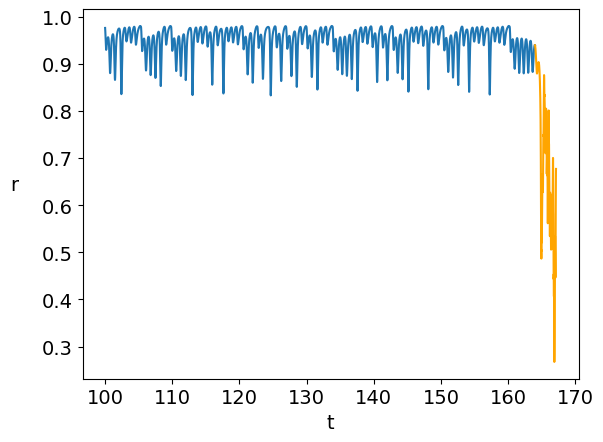

In [55]:

rtest= np.sqrt((np.cos(Xtest).sum(axis=0))**2+(np.sin(Xtest).sum(axis=0))**2)/N
plt.plot(T[:5000+minter],rtest[:5000+minter])
plt.plot(T[5000+minter:Xind3d[1]+5000],rtest[5000+minter:Xind3d[1]+5000],color='orange')
plt.ylabel('r',rotation=0,fontsize=14, labelpad=20)
plt.xlabel('t',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'rcollapse.jpg',dpi = 250, bbox_inches = 'tight')

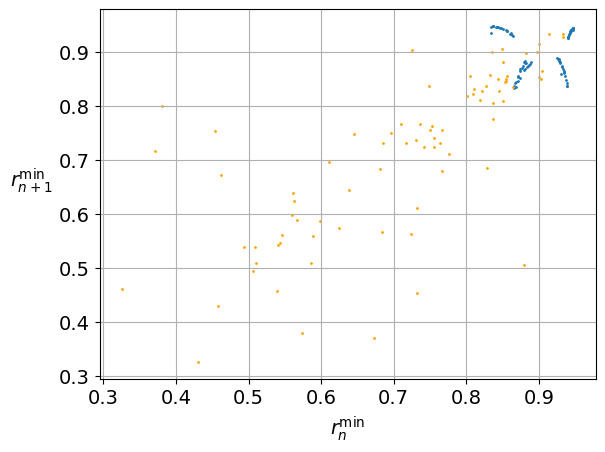

In [56]:
drmin = []
ilist = []
dr= rtest[1:] - rtest[:-1]
tlist = []
T=np.arange(100,200,0.01)
for i,t in zip(range(0,len(dr)-1),T[:-1]):
    if np.round(dr[i],5)<0 and np.round(dr[i+1],5)>0:
        drmin.append(rtest[i])
        ilist.append(i)
        tlist.append(t)
tarray= np.array(tlist)
drmin=np.array(drmin)
plt.scatter(drmin[:-1][tarray[:-1]<164], drmin[1:][tarray[:-1]<164],s=1)
plt.scatter(drmin[:-1][(tarray[:-1]>=164) & (tarray[:-1]<171.4)], drmin[1:][(tarray[:-1]>=164) & (tarray[:-1]<171.4)],s=1,color='orange')
plt.xlabel('$r_n^{\min}$',fontsize=14,rotation=0)
plt.ylabel('$r_{n+1}^{\min}$',fontsize=14,rotation=0,labelpad=20)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'rmincollapse.jpg',dpi = 250, bbox_inches = 'tight')